<a href="https://colab.research.google.com/github/wantor-stack/Demand-Forecasting/blob/main/notebook_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasts for Product Demand**
## *Make Accurate Forecasts for Thousands of Different Products*
<br>

## **Time Series Forecasting Template**

* ### 1. Business understanding and performance metrics definition
* ### 2. Data ingestion
* ### 3. Data exploration and understanding
* ### 4. Data pre-processing and feature engineering
* ### 5. Modeling building and selection
* ### 6. Model deployment
* ### 7. Forecasting solution acceptance
<br>

# 1. Business understanding and performance metrics definition

### **Context**

The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

### **Content**

Historical Product Demand.csv - CSV data file containing product demand for encoded product id's

### **Acknowledgements**
This dataset is all real-life data and products/warehouse and category information encoded.

### **Problem**
Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?

**Define the following forecasting aspects:**

    a) The inputs and outputs of your forecasting model
    b) Granularity level of your forecasting model
    c) Horizon of your forecasting model
    d) The endogenous and exogenous features of your forecasting model
    e) The structured or unstructured features of your forecasting model
    f) The univariate or multivariate nature of your forecasting model (The term univariate time series refers to one that consists of single observations recorded sequentially over equal time increments)
    g) Single-step or multi-step structure of your forecasting model
    h) Contiguous or noncontiguous time series values of your forecasting model

In [2]:
!pip install fastparquet

     |████████████████████████████████| 327kB 8.1MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 1.5MB 13.9MB/s 
     |████████████████████████████████| 122kB 38.0MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.6.3-cp37-cp37m-linux_x86_64.whl size=896348 sha256=0d2311a27c6147f55dbf14c8527daaa031a89859fb53e05ea56dcf4ada5823e0
  Stored in directory: /root/.cache/pip/wheels/62/58/37/72cfb2147ea35b5317bbf01a1d266777a6d49c38c12f327c1b
  Created wheel for thrift: filename=thrift-0.13.0-cp37-cp37m-linux_x86_64.whl size=348155 sha256=59602f65056eba3b0eb0827477295b4cc668359cbf7c75c178692b689c41a00b
  Stored in directory: /root/.cache/pip/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
Successfully built fastparquet thrift


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from fastparquet import write, ParquetFile

# 2. Data ingestion

In [4]:
df = pd.read_csv('Historical Product Demand.csv')

# 3. Data exploration and understanding

In [5]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [6]:
# Dimension
print("Rows: {} Columns: {}".format(df.shape[0], df.shape[1]))

Rows: 1048575 Columns: 5


In [7]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [8]:
# Change Date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [9]:
#Totals

print("Total Product Categories: {} ".format(len(df['Product_Category'].unique())))
print("Total Warehouses: {} ".format(len(df['Warehouse'].unique())))
print("Total Products: {} ".format(len(df['Product_Code'].unique())))

Total Product Categories: 33 
Total Warehouses: 4 
Total Products: 2160 


In [10]:
dates1 = [pd.to_datetime(date) for date in df['Date']]
dates1.sort()
print("Start Date: {}".format(dates1[0]))
print("Final Date: {}".format(dates1[-1]))
n_days = dates1[-1] - dates1[0]
print("N Days: {}".format(n_days))

Start Date: 2011-01-08 00:00:00
Final Date: 2017-01-09 00:00:00
N Days: 2193 days 00:00:00


# 4. Data pre-processing and feature engineering

## 4.1 Data Pre-processing

In [11]:
df['Order_Demand'].unique()

array(['100 ', '500 ', '50000 ', ..., '(3750)', '(191)', '28250 '],
      dtype=object)

In [12]:
# Change Order Demand format
df['Order_Demand']=df['Order_Demand'].str.replace('(',"")
df['Order_Demand']=df['Order_Demand'].str.replace(')',"")

df['Order_Demand']=df['Order_Demand'].str.strip()
df['Order_Demand']=df['Order_Demand'].str.strip()

# Since the "()" has been removed , we could change the data type
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [13]:
# Missing Data
# Lets check where these nulls are
print(df.isna().sum())
print("")
print ('% of Null Dates in the Dataset: ',df.isnull().sum()[3]/df.shape[0]*100)
# There are missing values in Dates

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

% of Null Dates in the Dataset:  1.0718355863910547


In [14]:
# Drop na's.

# Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;)

df.dropna(axis=0, inplace=True) # Remove all rows with na's.
df.reset_index(drop=True).head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [15]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [16]:
# Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.

df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)


In [17]:
# Sum the demand per day

df = df.groupby(["Warehouse", "Product_Code", "Product_Category", "Date"])[["Order_Demand"]].sum().reset_index()

In [18]:
df.head()

,Warehouse,Product_Code,Product_Category,Date,Order_Demand
0,Whse_A,Product_0001,Category_005,2012-01-03,1000
1,Whse_A,Product_0001,Category_005,2012-01-04,200
2,Whse_A,Product_0001,Category_005,2012-01-09,2000
3,Whse_A,Product_0001,Category_005,2012-01-10,3000
4,Whse_A,Product_0001,Category_005,2012-01-30,200


In [19]:
df.shape

(633974, 5)

In [20]:
# Check if any dates are missing
daily_data = pd.DataFrame(pd.date_range(start=df['Date'].min(),end=df['Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


,Date
count,1826
unique,1826
top,2016-11-14 00:00:00
freq,1
first,2012-01-01 00:00:00
last,2016-12-30 00:00:00


In [21]:
daily_data.head()

,Date
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05


In [22]:
df = df.set_index(["Warehouse", "Product_Category","Product_Code", "Date"])[["Order_Demand"]].unstack().fillna(0)
df.columns = df.columns.get_level_values(1)

In [23]:
df.head()

Date                                     2012-01-01  ...  2016-12-30
Warehouse Product_Category Product_Code              ...            
Whse_A    Category_001     Product_1751         0.0  ...         0.0
          Category_003     Product_1180         0.0  ...         0.0
                           Product_1719         0.0  ...         0.0
                           Product_1724         0.0  ...         0.0
                           Product_1725         0.0  ...         0.0

[5 rows x 1681 columns]

In [24]:
df = df.T

In [25]:
df

Warehouse              Whse_A               ...       Whse_S             
Product_Category Category_001 Category_003  ... Category_032             
Product_Code     Product_1751 Product_1180  ... Product_1052 Product_1101
Date                                        ...                          
2012-01-01                0.0          0.0  ...          0.0          0.0
2012-01-02                0.0          0.0  ...          0.0          0.0
2012-01-03                0.0          0.0  ...          0.0          0.0
2012-01-04                0.0          0.0  ...          0.0          0.0
2012-01-05                0.0          0.0  ...          0.0          0.0
...                       ...          ...  ...          ...          ...
2016-12-26                0.0          0.0  ...          0.0      50000.0
2016-12-27                0.0          0.0  ...          0.0          0.0
2016-12-28                0.0          0.0  ...          0.0       2000.0
2016-12-29                0.0          0.0  ...          0.0          0.0
2016-12-30                0.0          0.0  ...          0.0          0.0

[1681 rows x 2849 columns]

In [26]:
df.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [27]:
# Add the missing dates

idx = pd.date_range(start='2012-01-01',end='2016-12-30')

In [28]:
df = df.reindex(idx, fill_value=0)

In [29]:
df

Warehouse              Whse_A               ...       Whse_S             
Product_Category Category_001 Category_003  ... Category_032             
Product_Code     Product_1751 Product_1180  ... Product_1052 Product_1101
2012-01-01                0.0          0.0  ...          0.0          0.0
2012-01-02                0.0          0.0  ...          0.0          0.0
2012-01-03                0.0          0.0  ...          0.0          0.0
2012-01-04                0.0          0.0  ...          0.0          0.0
2012-01-05                0.0          0.0  ...          0.0          0.0
...                       ...          ...  ...          ...          ...
2016-12-26                0.0          0.0  ...          0.0      50000.0
2016-12-27                0.0          0.0  ...          0.0          0.0
2016-12-28                0.0          0.0  ...          0.0       2000.0
2016-12-29                0.0          0.0  ...          0.0          0.0
2016-12-30                0.0          0.0  ...          0.0          0.0

[1826 rows x 2849 columns]

In [30]:
df=df.T

In [31]:
df

2012-01-01  ...  2016-12-30
Warehouse Product_Category Product_Code              ...            
Whse_A    Category_001     Product_1751         0.0  ...         0.0
          Category_003     Product_1180         0.0  ...         0.0
                           Product_1719         0.0  ...         0.0
                           Product_1724         0.0  ...         0.0
                           Product_1725         0.0  ...         0.0
...                                             ...  ...         ...
Whse_S    Category_032     Product_0592         0.0  ...         0.0
                           Product_0593         0.0  ...         0.0
                           Product_0595         0.0  ...         0.0
                           Product_1052         0.0  ...         0.0
                           Product_1101         0.0  ...         0.0

[2849 rows x 1826 columns]

In [44]:
stacked_df=pd.DataFrame(df.stack())
stacked_df


0
Warehouse Product_Category Product_Code                    
Whse_A    Category_001     Product_1751 2012-01-01      0.0
                                        2012-01-02      0.0
                                        2012-01-03      0.0
                                        2012-01-04      0.0
                                        2012-01-05      0.0
...                                                     ...
Whse_S    Category_032     Product_1101 2016-12-26  50000.0
                                        2016-12-27      0.0
                                        2016-12-28   2000.0
                                        2016-12-29      0.0
                                        2016-12-30      0.0

[5202274 rows x 1 columns]

In [45]:
stacked_df = stacked_df.reset_index()

In [46]:
stacked_df

,Warehouse,Product_Category,Product_Code,level_3,0
0,Whse_A,Category_001,Product_1751,2012-01-01,0.0
1,Whse_A,Category_001,Product_1751,2012-01-02,0.0
2,Whse_A,Category_001,Product_1751,2012-01-03,0.0
3,Whse_A,Category_001,Product_1751,2012-01-04,0.0
4,Whse_A,Category_001,Product_1751,2012-01-05,0.0
...,...,...,...,...,...
5202269,Whse_S,Category_032,Product_1101,2016-12-26,50000.0
5202270,Whse_S,Category_032,Product_1101,2016-12-27,0.0
5202271,Whse_S,Category_032,Product_1101,2016-12-28,2000.0
5202272,Whse_S,Category_032,Product_1101,2016-12-29,0.0


In [47]:
stacked_df.rename(columns = {'level_3':'Date', 0:'Order_Demand'}, inplace = True)

In [48]:
stacked_df = stacked_df.sort_values(by=['Warehouse','Product_Code', 'Date'])

In [49]:
stacked_df.shape

(5202274, 5)

In [50]:
stacked_df.to_parquet("stacked_df.parquet")

In [5]:
full = pd.read_parquet("stacked_df.parquet").sort_values("Date")

In [6]:
full.shape

(5202274, 5)

# Create the Target

In [39]:
# Predict 7 days ahead

# Just for studies we will choose the Direct Method

full_direct = []
lead_t = 4

for Product_Code, Product_Code_df in full.groupby(['Product_Code', 'Warehouse']):
    Product_Code_df = Product_Code_df.copy()
    
    Product_Code_df['Y{}'.format(lead_t)] = Product_Code_df['Order_Demand'].shift(-lead_t)
    Product_Code_df = Product_Code_df.iloc[:-lead_t]
    
    full_direct.append(Product_Code_df)
    
    #break
full_direct_df = pd.concat(full_direct, axis=0, ignore_index=True)

KeyboardInterrupt: ignored

In [8]:
full_direct_df.head()

,Warehouse,Product_Category,Product_Code,Date,Order_Demand,Y7
0,Whse_A,Category_005,Product_0001,2012-01-01,0.0,0.0
1,Whse_A,Category_005,Product_0001,2012-01-02,0.0,2000.0
2,Whse_A,Category_005,Product_0001,2012-01-03,1000.0,3000.0
3,Whse_A,Category_005,Product_0001,2012-01-04,200.0,0.0
4,Whse_A,Category_005,Product_0001,2012-01-05,0.0,0.0


In [9]:
full_direct_df.to_parquet("full_direct_df.parquet")

In [21]:
full_direct_df = pd.read_parquet("full_direct_df.parquet").sort_values("Date")

In [22]:
full_direct_df.shape

(5182331, 6)

# Split

In [28]:
full_direct_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5182331 entries, 0 to 5182330
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Warehouse         object        
 1   Product_Category  object        
 2   Product_Code      object        
 3   Date              datetime64[ns]
 4   Order_Demand      float64       
 5   Y7                float64       
 6   Week              int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 316.3+ MB


In [23]:
full_direct_df["Date"].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 5182331
unique                   1819
top       2015-12-15 00:00:00
freq                     2849
first     2012-01-01 00:00:00
last      2016-12-23 00:00:00
Name: Date, dtype: object

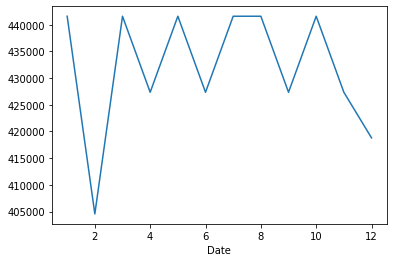

In [24]:
full_direct_df.groupby(full_direct_df['Date'].dt.month).size().plot()

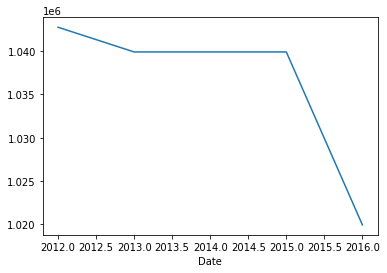

In [25]:
full_direct_df.groupby(full_direct_df['Date'].dt.year).size().plot()

In [31]:
full_direct_df['Week'] = full_direct_df['Date'].dt.week
full_direct_df['Year'] = full_direct_df['Date'].dt.year
full_direct_df['Month'] = full_direct_df['Date'].dt.month
full_direct_df['Day'] = full_direct_df['Date'].dt.day
full_direct_df['WeekDay'] = full_direct_df['Date'].dt.weekday

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [32]:
full_direct_df.head()

,Warehouse,Product_Category,Product_Code,Date,Order_Demand,Y7,Week,Year,Month,Day,WeekDay
0,Whse_A,Category_005,Product_0001,2012-01-01,0.0,0.0,52,2012,1,1,6
172805,Whse_J,Category_019,Product_0073,2012-01-01,0.0,0.0,52,2012,1,1,6
1817181,Whse_J,Category_001,Product_0735,2012-01-01,0.0,0.0,52,2012,1,1,6
3365150,Whse_C,Category_019,Product_1431,2012-01-01,0.0,0.0,52,2012,1,1,6
2639369,Whse_A,Category_009,Product_1138,2012-01-01,0.0,0.0,52,2012,1,1,6


In [40]:
full_week = full_direct_df.groupby(['Warehouse','Product_Category','Product_Code','Year','Month','Week'])[['Order_Demand']].sum().reset_index()
#df.groupby(["Warehouse", "Product_Code", "Product_Category", "Date"])[["Order_Demand"]].sum().reset_index()

In [41]:
print(full_week['Order_Demand'].sum())
#print(full_week['Y7'].sum())

5116238730.0


In [68]:
full_week.head()

,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand
0,Whse_A,Category_001,Product_1751,2012,1,1,0.0
1,Whse_A,Category_001,Product_1751,2012,1,2,0.0
2,Whse_A,Category_001,Product_1751,2012,1,3,0.0
3,Whse_A,Category_001,Product_1751,2012,1,4,0.0
4,Whse_A,Category_001,Product_1751,2012,1,5,0.0


In [69]:
full_week.shape

(888888, 7)

In [78]:
# Predict 4 weeks ahead

# Just for studies we will choose the Direct Method

full_wdirect = []
lead_t = 4

for Product_Code, Product_Code_df in full_week.groupby(['Product_Code', 'Warehouse']):
    Product_Code_df = Product_Code_df.copy()
    
    Product_Code_df['Y{}'.format(lead_t)] = Product_Code_df['Order_Demand'].shift(-lead_t)
    Product_Code_df = Product_Code_df.iloc[:-lead_t]
    
    full_wdirect.append(Product_Code_df)
    
    #break
full_week_direct = pd.concat(full_wdirect, axis=0, ignore_index=True)

In [79]:
full_week_direct

,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4
0,Whse_A,Category_005,Product_0001,2012,1,1,1200.0,200.0
1,Whse_A,Category_005,Product_0001,2012,1,2,5000.0,0.0
2,Whse_A,Category_005,Product_0001,2012,1,3,0.0,0.0
3,Whse_A,Category_005,Product_0001,2012,1,4,0.0,3000.0
4,Whse_A,Category_005,Product_0001,2012,1,5,200.0,0.0
...,...,...,...,...,...,...,...,...
877487,Whse_J,Category_005,Product_2172,2016,11,44,0.0,600.0
877488,Whse_J,Category_005,Product_2172,2016,11,45,0.0,0.0
877489,Whse_J,Category_005,Product_2172,2016,11,46,0.0,0.0
877490,Whse_J,Category_005,Product_2172,2016,11,47,300.0,0.0


In [80]:
full_week_direct.columns

Index(['Warehouse', 'Product_Category', 'Product_Code', 'Year', 'Month',
       'Week', 'Order_Demand', 'Y4'],
      dtype='object')

In [81]:
full_week_direct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877492 entries, 0 to 877491
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Warehouse         877492 non-null  object 
 1   Product_Category  877492 non-null  object 
 2   Product_Code      877492 non-null  object 
 3   Year              877492 non-null  int64  
 4   Month             877492 non-null  int64  
 5   Week              877492 non-null  int64  
 6   Order_Demand      877492 non-null  float64
 7   Y4                877492 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 53.6+ MB


In [82]:
full_week_direct.index

RangeIndex(start=0, stop=877492, step=1)

In [83]:
full_week_direct.to_parquet("full_week_direct.parquet")

In [78]:
full_week_direct = pd.read_parquet("full_week_direct.parquet").sort_values(['Warehouse','Product_Code','Year', 'Month', 'Week'])

In [79]:
full_week_direct

,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4
0,Whse_A,Category_005,Product_0001,2012,1,1,1200.0,200.0
1,Whse_A,Category_005,Product_0001,2012,1,2,5000.0,0.0
2,Whse_A,Category_005,Product_0001,2012,1,3,0.0,0.0
3,Whse_A,Category_005,Product_0001,2012,1,4,0.0,3000.0
4,Whse_A,Category_005,Product_0001,2012,1,5,200.0,0.0
...,...,...,...,...,...,...,...,...
876563,Whse_S,Category_024,Product_2169,2016,11,44,0.0,25.0
876564,Whse_S,Category_024,Product_2169,2016,11,45,0.0,0.0
876565,Whse_S,Category_024,Product_2169,2016,11,46,0.0,0.0
876566,Whse_S,Category_024,Product_2169,2016,11,47,0.0,0.0


In [102]:
split_year = 2015
train = full_week_direct[full_week_direct['Year'] <= split_year]
val = full_week_direct[full_week_direct['Year'] > split_year]
train.shape, val.shape


((715099, 8), (162393, 8))

In [103]:
# Drop Outliers in train dataset

winsor_lower = np.percentile(train['Y4'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train['Y4'], 99)

winsor_lower = np.percentile(train['Order_Demand'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train['Order_Demand'], 99)

#train['ORDER_WIN'] = train['Order_Demand'].clip(lower=winsor_lower, upper=winsor_upper)
#train['Y4WIN'] = train['Y4'].clip(lower=winsor_lower, upper=winsor_upper)


train.reset_index().to_parquet("train.parquet")
val.reset_index().to_parquet("val.parquet")

In [104]:
train = pd.read_parquet("train.parquet").sort_values(['Warehouse','Product_Code','Year', 'Month', 'Week'])
val = pd.read_parquet("val.parquet").sort_values(['Warehouse','Product_Code','Year', 'Month', 'Week'])

In [105]:
train.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4
0,0,Whse_A,Category_005,Product_0001,2012,1,1,1200.0,200.0
1,1,Whse_A,Category_005,Product_0001,2012,1,2,5000.0,0.0
2,2,Whse_A,Category_005,Product_0001,2012,1,3,0.0,0.0
3,3,Whse_A,Category_005,Product_0001,2012,1,4,0.0,3000.0
4,4,Whse_A,Category_005,Product_0001,2012,1,5,200.0,0.0


# Baseline

In [106]:
train2 = train.copy()
#train2['WEEKDAY'] = train2['Date'].dt.weekday
#train2['WEEK'] = train2['Date'].dt.week

train2['SMA_3'] = train2.iloc[:,7].rolling(window=3).mean()

In [107]:
train2['SMA_3'] = train2['SMA_3'].replace(np.nan,0)

In [108]:
train2

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3
0,0,Whse_A,Category_005,Product_0001,2012,1,1,1200.0,200.0,0.000000
1,1,Whse_A,Category_005,Product_0001,2012,1,2,5000.0,0.0,0.000000
2,2,Whse_A,Category_005,Product_0001,2012,1,3,0.0,0.0,2066.666667
3,3,Whse_A,Category_005,Product_0001,2012,1,4,0.0,3000.0,1666.666667
4,4,Whse_A,Category_005,Product_0001,2012,1,5,200.0,0.0,66.666667
...,...,...,...,...,...,...,...,...,...,...
715094,876506,Whse_S,Category_024,Product_2169,2015,12,49,0.0,400.0,16.666667
715095,876507,Whse_S,Category_024,Product_2169,2015,12,50,0.0,0.0,16.666667
715096,876508,Whse_S,Category_024,Product_2169,2015,12,51,22.0,0.0,7.333333
715097,876509,Whse_S,Category_024,Product_2169,2015,12,52,0.0,0.0,7.333333


In [109]:
val2 = val.copy()
#val2['WEEKDAY'] = val2['Date'].dt.weekday
#val2['WEEK'] = val2['Date'].dt.week


val2['SMA_3'] = val2.iloc[:,7].rolling(window=3).mean().replace(np.nan,0)
val2.head(10)

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3
0,251,Whse_A,Category_005,Product_0001,2016,1,1,0.0,0.0,0.000000
1,252,Whse_A,Category_005,Product_0001,2016,1,2,0.0,200.0,0.000000
2,253,Whse_A,Category_005,Product_0001,2016,1,3,100.0,1000.0,33.333333
3,254,Whse_A,Category_005,Product_0001,2016,1,4,0.0,2000.0,33.333333
4,255,Whse_A,Category_005,Product_0001,2016,1,53,0.0,2000.0,33.333333
5,256,Whse_A,Category_005,Product_0001,2016,2,5,200.0,0.0,66.666667
6,257,Whse_A,Category_005,Product_0001,2016,2,6,1000.0,2000.0,400.000000
7,258,Whse_A,Category_005,Product_0001,2016,2,7,2000.0,0.0,1066.666667
8,259,Whse_A,Category_005,Product_0001,2016,2,8,2000.0,1000.0,1666.666667
9,260,Whse_A,Category_005,Product_0001,2016,2,9,0.0,3000.0,1333.333333


In [110]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# median_absolute_error(val2['Y4'],val2['P'])
#print(median_absolute_error(train2['Order_Demand'], train2['SMA_3']))
print('MAE: {}'.format(median_absolute_error(val2['Order_Demand'], val2['SMA_3'])))
#print('R2: {}'.format(r2_score(val2['Order_Demand'], val2['SMA_3'])))

MAE: 9.333333333333332


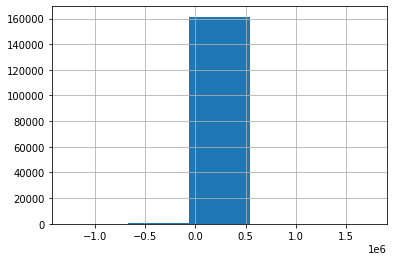

In [111]:
(val2['Order_Demand']-val2['SMA_3']).hist(bins=5)

# Tratando os dados categóricos

In [112]:
# Transform with LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train2['Product_Code'] = le.fit_transform(train2['Product_Code'].values)
train2['Warehouse'] = le.fit_transform(train2['Warehouse'].values)
train2['Product_Category'] = le.fit_transform(train2['Product_Category'].values)

val2['Product_Code'] = le.fit_transform(val2['Product_Code'].values)
val2['Warehouse'] = le.fit_transform(val2['Warehouse'].values)
val2['Product_Category'] = le.fit_transform(val2['Product_Category'].values)

In [113]:
#Suavization the order demand SERIES

train2['Order_Demand'] =  train2['Order_Demand'].apply(pd.np.log1p) # logarithm conversion
#train2['ORDER_WIN'] =  train2['ORDER_WIN'].apply(pd.np.log1p) # logarithm conversion
train2['Y4'] =  train2['Y4'].apply(pd.np.log1p) # logarithm conversion
#train2['Y4WIN'] =  train2['Y4WIN'].apply(pd.np.log1p) # logarithm conversion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


In [114]:
# Normalization the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train2[['Warehouse',	'Product_Category',	'Product_Code', 'Year',	'Month','Week']] = scaler.fit_transform(train2[['Warehouse',	'Product_Category',	'Product_Code', 'Year',	'Month','Week']].to_numpy())

val2[['Warehouse',	'Product_Category',	'Product_Code', 'Year',	'Month','Week']] = scaler.transform(val2[['Warehouse',	'Product_Category',	'Product_Code', 'Year',	'Month','Week']].to_numpy())

In [115]:
#Suavization the order demand (val2)
val2['Order_Demand'] =  val2['Order_Demand'].apply(pd.np.log1p) # logarithm conversion
val2['Y4'] =  val2['Y4'].apply(pd.np.log1p)
#val2['ORDER_WIN'] =  val2['ORDER_WIN'].apply(pd.np.log1p) # logarithm conversion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
train2.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3
0,0,0.0,0.125,0.0,0.0,0.0,0.000000,7.090910,5.303305,0.000000
1,1,0.0,0.125,0.0,0.0,0.0,0.019231,8.517393,0.000000,0.000000
2,2,0.0,0.125,0.0,0.0,0.0,0.038462,0.000000,0.000000,2066.666667
3,3,0.0,0.125,0.0,0.0,0.0,0.057692,0.000000,8.006701,1666.666667
4,4,0.0,0.125,0.0,0.0,0.0,0.076923,5.303305,0.000000,66.666667


In [117]:
val2.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3
0,251,0.0,0.125,0.0,1.333333,0.0,0.000000,0.000000,0.000000,0.000000
1,252,0.0,0.125,0.0,1.333333,0.0,0.019231,0.000000,5.303305,0.000000
2,253,0.0,0.125,0.0,1.333333,0.0,0.038462,4.615121,6.908755,33.333333
3,254,0.0,0.125,0.0,1.333333,0.0,0.057692,0.000000,7.601402,33.333333
4,255,0.0,0.125,0.0,1.333333,0.0,1.000000,0.000000,7.601402,33.333333


In [118]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[['Warehouse','Product_Category','Product_Code','Year','Month','Week']], train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[['Warehouse','Product_Category','Product_Code','Year','Month','Week']])
print('MAE: {}'.format(median_absolute_error(val2['Y4'], p)))
#print(r2_score(val2['Y4'], p))

MAE: 1.1186914117035416


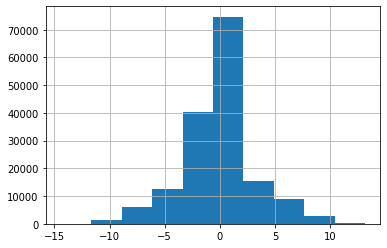

In [119]:
(val2['Order_Demand']-p).hist(bins=10)

In [120]:
train2.columns

Index(['index', 'Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week', 'Order_Demand', 'Y4', 'SMA_3'],
      dtype='object')

In [150]:
# Inserindo LAGS

lags = [1,2,4,8,12]

train3 = list()
new_features = set()

features = ["Order_Demand"]

for Product_Code, Product_Code_df in train2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            Product_Code_df['LAG{}_{}'.format(l, f)] = Product_Code_df[f].shift(l)
        
    train3.append(Product_Code_df)
train3 = pd.concat(train3, ignore_index=True).fillna(-1)


val3 = list()
for Product_Code, Product_Code_df in val2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            Product_Code_df['LAG{}_{}'.format(l, f)] = Product_Code_df[f].shift(l)
        
    val3.append(Product_Code_df)
val3 = pd.concat(val3, ignore_index=True).fillna(-1)

In [151]:
train3.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3,LAG1_Order_Demand,LAG2_Order_Demand,LAG4_Order_Demand,LAG8_Order_Demand,LAG12_Order_Demand
0,701008,0.0,0.0,0.805929,0.0,0.0,0.000000,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,701009,0.0,0.0,0.805929,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0
2,701010,0.0,0.0,0.805929,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
3,701011,0.0,0.0,0.805929,0.0,0.0,0.057692,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
4,701012,0.0,0.0,0.805929,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0


In [152]:
val3.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3,LAG1_Order_Demand,LAG2_Order_Demand,LAG4_Order_Demand,LAG8_Order_Demand,LAG12_Order_Demand
0,701259,0.0,0.0,0.805929,1.333333,0.0,0.000000,0.000000,2.397895,6.666667,-1.000000,-1.000000,-1.0,-1.0,-1.0
1,701260,0.0,0.0,0.805929,1.333333,0.0,0.019231,0.693147,3.091042,7.000000,0.000000,-1.000000,-1.0,-1.0,-1.0
2,701261,0.0,0.0,0.805929,1.333333,0.0,0.038462,3.044522,3.044522,7.000000,0.693147,0.000000,-1.0,-1.0,-1.0
3,701262,0.0,0.0,0.805929,1.333333,0.0,0.057692,0.000000,0.000000,7.000000,3.044522,0.693147,-1.0,-1.0,-1.0
4,701263,0.0,0.0,0.805929,1.333333,0.0,1.000000,2.397895,3.465736,10.000000,0.000000,3.044522,0.0,-1.0,-1.0


In [148]:
train3.columns

Index(['index', 'Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week', 'Order_Demand', 'Y4', 'SMA_3', 'LAG1_Order_Demand',
       'LAG2_Order_Demand', 'LAG4_Order_Demand', 'LAG8_Order_Demand',
       'LAG12_Order_Demand'],
      dtype='object')

In [154]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

features = ['Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week'] + list(new_features)

Xtr, ytr = train3[features], train3['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val3[features])
print('MAE: {}'.format(median_absolute_error(val3['Y4'], p)))
#print(r2_score(val2['Y4'], p))

MAE: 1.550745702655686


In [ ]:
# Inserindo DIFF

In [159]:
lags = [1,2,4,8,12]

train4 = list()
new_features = set()

features = ["Order_Demand"]

for Product_Code, Product_Code_df in train2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            new_features.add('DIFF{}_{}'.format(l, f))
            Product_Code_df['DIFF{}_{}'.format(l, f)] = Product_Code_df[f].diff(l)
        
    train4.append(Product_Code_df)
train4 = pd.concat(train4, ignore_index=True)


val4 = list()
for Product_Code, Product_Code_df in val2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            Product_Code_df['DIFF{}_{}'.format(l, f)] = Product_Code_df[f].diff(l)
        
    val4.append(Product_Code_df)
val4 = pd.concat(val4, ignore_index=True)

In [160]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

features = ['Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week'] + list(new_features)

Xtr, ytr = train4[features].fillna(-1), train4['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val4[features].fillna(-1))

print('MAE: {}'.format(median_absolute_error(val4['Y4'], p)))


MAE: 1.620426614691187


In [ ]:
# Inserindo Rolling statistics

In [164]:
lags = [1,2,4,8,12]

train5 = list()
new_features = set()

features = ["Order_Demand"]

for Product_Code, Product_Code_df in train2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            Product_Code_df['ROLL_MEAN{}_{}'.format(l, f)] = Product_Code_df[f].rolling(l).mean()
        
    train5.append(Product_Code_df)
train5 = pd.concat(train5, ignore_index=True)


val5 = list()
for Product_Code, Product_Code_df in val2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            Product_Code_df['ROLL_MEAN{}_{}'.format(l, f)] = Product_Code_df[f].rolling(l).mean()
        
    val5.append(Product_Code_df)
val5 = pd.concat(val5, ignore_index=True)

In [165]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

features = ['Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week'] + list(new_features)

Xtr, ytr = train5[features].fillna(-1), train5['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val5[features].fillna(-1))

print('MAE: {}'.format(median_absolute_error(val5['Y4'], p)))

MAE: 1.4677616205909307


In [ ]:
# All Together

In [166]:
lags = [1,2,4,8,12]

train6 = list()
new_features = set()

features = ["Order_Demand"]

for Product_Code, Product_Code_df in train2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            Product_Code_df['ROLL_MEAN{}_{}'.format(l, f)] = Product_Code_df[f].rolling(l).mean()

            new_features.add('DIFF{}_{}'.format(l, f))
            Product_Code_df['DIFF{}_{}'.format(l, f)] = Product_Code_df[f].diff(l)

            new_features.add('LAG{}_{}'.format(l, f))
            Product_Code_df['LAG{}_{}'.format(l, f)] = Product_Code_df[f].shift(l)

    train6.append(Product_Code_df)
train6 = pd.concat(train6, ignore_index=True)


val6 = list()
for Product_Code, Product_Code_df in val2.groupby(['Warehouse', 'Product_Category', 'Product_Code']):
    Product_Code_df = Product_Code_df.copy()
    for f in features:
        for l in lags:
            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            Product_Code_df['ROLL_MEAN{}_{}'.format(l, f)] = Product_Code_df[f].rolling(l).mean()

            new_features.add('DIFF{}_{}'.format(l, f))
            Product_Code_df['DIFF{}_{}'.format(l, f)] = Product_Code_df[f].diff(l)

            new_features.add('LAG{}_{}'.format(l, f))
            Product_Code_df['LAG{}_{}'.format(l, f)] = Product_Code_df[f].shift(l)
        
    val6.append(Product_Code_df)
val6 = pd.concat(val6, ignore_index=True)

In [167]:
train6.head()

,index,Warehouse,Product_Category,Product_Code,Year,Month,Week,Order_Demand,Y4,SMA_3,ROLL_MEAN1_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MEAN8_Order_Demand,ROLL_MEAN12_Order_Demand,DIFF1_Order_Demand,DIFF2_Order_Demand,DIFF4_Order_Demand,DIFF8_Order_Demand,DIFF12_Order_Demand,LAG1_Order_Demand,LAG2_Order_Demand,LAG4_Order_Demand,LAG8_Order_Demand,LAG12_Order_Demand
0,701008,0.0,0.0,0.805929,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,701009,0.0,0.0,0.805929,0.0,0.0,0.019231,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,701010,0.0,0.0,0.805929,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,701011,0.0,0.0,0.805929,0.0,0.0,0.057692,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,701012,0.0,0.0,0.805929,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN


In [169]:
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

features = ['Warehouse', 'Product_Category', 'Product_Code', 'Year',
       'Month', 'Week'] + list(new_features)

Xtr, ytr = train6[features].fillna(-1), train6['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val6[features].fillna(-1))

print('MAE: {}'.format(median_absolute_error(val6['Y4'], p)))

MAE: 1.4496640186297347


# Baseline ML

In [89]:
train.columns

Index(['Warehouse', 'Product_Category', 'Product_Code', 'Date', 'Order_Demand',
       'Y7', 'Y7WIN'],
      dtype='object')

In [ ]:
features = 

In [96]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]



In [105]:
def prepare_dataset(tdate, is_train=True):
    X = pd.DataFrame({
        "mean_3_days": get_timespan(df, tdate, 3, 3).mean(axis=1).values,
        "mean_7_days": get_timespan(df, tdate, 7, 7).mean(axis=1).values,
        "mean_14_days": get_timespan(df, tdate, 14, 14).mean(axis=1).values,
        "mean_30_days": get_timespan(df, tdate, 30, 30).mean(axis=1).values,
    })
    #for i in range(15):
    #   X["promo_{}".format(i)] = promo_2017[
    #       t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df[
            pd.date_range(t2017, periods=15)
        ].values
        return X, y
    return X

In [ ]:
print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

In [136]:
# Split train and test
df_train = df[(df['Date']>='2012-01-01') & (df['Date']<='2015-12-31')]
df_test = df[(df['Date']>='2016-01-01')]

# Working with df_train

In [137]:
df_train.head()

,Warehouse,Product_Code,Product_Category,Date,Order_Demand
0,Whse_A,Product_0001,Category_005,2012-01-03,1000
1,Whse_A,Product_0001,Category_005,2012-01-04,200
2,Whse_A,Product_0001,Category_005,2012-01-09,2000
3,Whse_A,Product_0001,Category_005,2012-01-10,3000
4,Whse_A,Product_0001,Category_005,2012-01-30,200


In [138]:
# transform train dataset

df_train.loc[(df_train.Order_Demand<0),'Order_Demand'] = 0 # eliminate negatives
df_train['Order_Demand'] =  df_train['Order_Demand'].apply(pd.np.log1p) # logarithm conversion
# del df_train

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sy

In [139]:
df_train = df_train.set_index(["Warehouse", "Product_Category","Product_Code", "Date"])[["Order_Demand"]].unstack().fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

In [140]:
df_train

Date                                     2012-01-01  ...  2015-12-31
Warehouse Product_Category Product_Code              ...            
Whse_A    Category_001     Product_1751         0.0  ...         0.0
          Category_003     Product_1180         0.0  ...         0.0
                           Product_1719         0.0  ...         0.0
                           Product_1724         0.0  ...         0.0
                           Product_1725         0.0  ...         0.0
...                                             ...  ...         ...
Whse_S    Category_032     Product_0592         0.0  ...         0.0
                           Product_0593         0.0  ...         0.0
                           Product_0595         0.0  ...         0.0
                           Product_1052         0.0  ...         0.0
                           Product_1101         0.0  ...         0.0

[2819 rows x 1360 columns]

In [102]:
# FEATURES DF_VAL

def features_dataset_val(dataframe,val_date):
    df_val = []
    y= []
    y = pd.DataFrame(y)
    df_val = pd.DataFrame(df_val)
    month = int(val_date.strftime('%m'))
    week = val_date.isocalendar()[1]
    for i in [10, 20, 30,40,50,60,120]:
        df_val['mean_for_-{}'.format(i)] = dataframe[pd.date_range(start =(val_date-timedelta(days=i)), periods=i, freq = 'D')].mean(axis=1)
        df_val['std_for_-{}'.format(i)] = dataframe[pd.date_range(start =(val_date-timedelta(days=i)), periods=i,freq = 'D')].std(axis=1)
        df_val['var_for_-{}'.format(i)] = dataframe[pd.date_range(start =(val_date-timedelta(days=i)), periods=i, freq = 'D')].var(axis=1)
        df_val['median_for_-{}'.format(i)] = dataframe[pd.date_range(start =(val_date-timedelta(days=i)),periods=i,freq = 'D')].median(axis=1)
        df_val['zero_sales_for_-{}'.format(i)] = dataframe[pd.date_range(start =(val_date-timedelta(days=i)), periods=i, freq = 'D')].apply(lambda x : list(x).count(0),axis=1)

    for i in range(7): #one month worth of day of week values
        df_val['mean_for_dow_4_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=28-i)),periods=4,freq='7D')].mean(axis=1)
        df_val['mean_for_dow_8_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=56-i)),periods=8,freq='7D')].mean(axis=1)
        df_val['mean_for_dow_16_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=112-i)),periods=16,freq='7D')].mean(axis=1)
        df_val['mean_for_dow_20_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=140-i)),periods=20,freq='7D')].mean(axis=1)
        df_val['zero_sales_for_dow_4_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=28-i)),periods=4,freq='7D')].apply(lambda x : list(x).count(0),axis=1)
        df_val['zero_sales_for_dow_8_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=56-i)),periods=8,freq='7D')].apply(lambda x : list(x).count(0),axis=1)
        df_val['zero_sales_for_dow_16_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=112-i)),periods=16,freq='7D')].apply(lambda x : list(x).count(0),axis=1)
        df_val['zero_sales_for_dow_20_{}'.format(i)] = dataframe[pd.date_range(start =(val_date - timedelta(days=140-i)),periods=20,freq='7D')].apply(lambda x : list(x).count(0),axis=1)

    for i in range(30):
        y['day{}'.format(i)] = dataframe[(val_date+timedelta(days=i))]
        #df_val['promo_{}'.format(i)] = test_train_promo_2017[val_date+timedelta(days=i)].values
    
    return df_val,y

In [104]:
val_date = date(2015, 6, 1)
X_train, y_train = features_dataset_val(df,val_date)

KeyError: ignored

In [94]:
df_val = []
df_val = pd.DataFrame(df_val)
month = int(val_date.strftime('%m'))
week = val_date.isocalendar()[1]
df_val['mean_for_-{}'.format(10)] = df[pd.date_range(start =(val_date-timedelta(days=10)), periods=10, freq = 'D')].mean(axis=1)

In [95]:
df_val

,mean_for_-10
0,0.0
1,3.6
2,10.8
3,32.4
4,0.0
...,...
2844,0.0
2845,0.0
2846,0.0
2847,93.6


In [63]:
import datetime
from datetime import timedelta, date
val_date = date(2015,6,30)
features_dataset_val(df, val_date)

KeyError: ignored

In [115]:
# Check if any dates are missing
#daily_data = pd.DataFrame(pd.date_range(start=df['Date'].min(),end=df['Date'].max()))
#daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
#daily_data.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


,Date
count,1826
unique,1826
top,2016-11-14 00:00:00
freq,1
first,2012-01-01 00:00:00
last,2016-12-30 00:00:00


### Create the Target

In [ ]:
#Chose the best method for multi-step forecasting: 
RECURSIVE: the last prevision is the imput the next
DIRECT: Go x steps directly to predict
NATIVE: multioutput prediction in a range of leads

In [ ]:
# Just for studies we will choose the Native Method
# We'd like to predict the next 7 days

df_native = []
min_lead_t = 1
max_lead_t = 4

for Product_Code, Product_Code_df in df.groupby(['Product_Code', 'Warehouse', 'Date']):
    Product_Code_df = Product_Code_df.sort_values('Date', ascending=True).copy()
    
    for lead_t in range(min_lead_t, max_lead_t+1):
        Product_Code_df['Y{}'.format(lead_t)] = Product_Code_df['Order_Demand'].shift(-lead_t)
        Product_Code_df = Product_Code_df.iloc[:-lead_t]
    
    df_native.append(Product_Code_df)
    
    #break
full_native_df = pd.concat(df_native, axis=0, ignore_index=True) 

KeyboardInterrupt: 

In [ ]:
full_native_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Y1,Y2,Y3,Y4,Y5,Y6,Y7
0,Product_0001,Whse_A,Category_005,2012-01-03,200,800.0,200.0,2000.0,2000.0,1000.0,200.0,3000.0
1,Product_0001,Whse_A,Category_005,2012-01-03,800,200.0,2000.0,2000.0,1000.0,200.0,3000.0,1000.0
2,Product_0001,Whse_A,Category_005,2012-01-04,200,2000.0,2000.0,1000.0,200.0,3000.0,1000.0,3000.0
3,Product_0001,Whse_A,Category_005,2012-01-09,2000,2000.0,1000.0,200.0,3000.0,1000.0,3000.0,400.0
4,Product_0001,Whse_A,Category_005,2012-01-10,2000,1000.0,200.0,3000.0,1000.0,3000.0,400.0,3000.0


## 4.2 Feature Enginnering

In [ ]:
from sklearn.preprocessing import LabelEncoder
#import lightgbm as lgb

In [ ]:
# Transform with LabelEncoder

le = LabelEncoder()
df['Product_Code'] = le.fit_transform(df['Product_Code'].values)
df['Warehouse'] = le.fit_transform(df['Warehouse'].values)
df['Product_Category'] = le.fit_transform(df['Product_Category'].values)

In [ ]:
# Create Year column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [ ]:
df['week_day'] = df['Date'].dt.weekday

In [ ]:
df=df.sort_values("Date")

In [ ]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day,week_day
130870,2153,3,23,2012-01-01,2,2012,1,1,6
75882,1331,3,18,2012-01-02,50000,2012,1,2,0
75881,1253,3,18,2012-01-02,2000,2012,1,2,0
75880,1253,3,18,2012-01-02,48000,2012,1,2,0
77219,1422,3,18,2012-01-02,4000,2012,1,2,0


In [ ]:
df.shape

(1036643, 9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


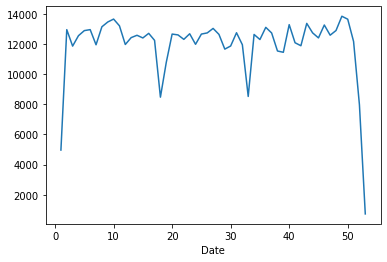

In [32]:
# Hold Out

df.groupby(df['Date'].dt.week).size().plot()

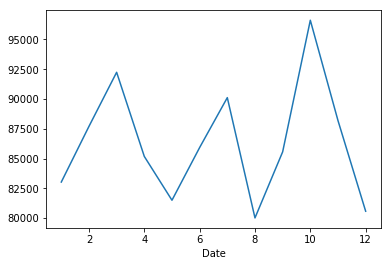

In [ ]:

df.groupby(df['Date'].dt.month).size().plot()

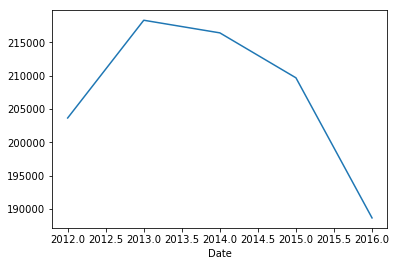

In [ ]:
df.groupby(df['Date'].dt.year).size().plot()

In [ ]:
split_date = "2015-12-31"
train = df[df['Date'] <= split_date]
val = df[df['Date'] > split_date]
train.shape, val.shape

((847998, 9), (188645, 9))

In [ ]:
#Save to parquet
train.reset_index().to_parquet("train.parquet")
val.reset_index().to_parquet("val.parquet")

### Normalization train and val

In [ ]:
#

## BASELINE ML

In [ ]:
train.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand',
       'Year', 'Month', 'Day', 'week_day'],
      dtype='object')

In [ ]:
features=['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand',
       'Year', 'Month', 'Day', 'week_day']
from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=1, random_state=0, n_estimators=100)
Xtr, ytr = train[features].fillna(-1), train['Order_Demand']
mdl.fit(Xtr, ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [ ]:
p = mdl.predict(val[features].fillna(-1))


C:\Users\Python\anaconda3\envs\tsa_course\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [ ]:
from sklearn.metrics import median_absolute_error
median_absolute_error(val['Order_Demand'], p)

0.0